# Gege Mayrendra

## Data Science Hck-04

# Working Area

## Problem Statement

`Student dipersilakan memilih topik antara Computer Vision atau Natural Language Processing menggunakan dataset sendiri (scraping oleh student) atau menggunakan open dataset.`

`from statement above, i decided to choose a dataset talking about expression recognition, in order this model could be implemented in any needed place`

### Import Libraries
`Importing data that we use during our project along with the library`

In [3]:
import math
import numpy as np
import pandas as pd

import cv2
!pip install scikit-plot
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`connecting google colab with google drive where the dataset saved`

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive

/content/drive/My Drive


`checking the possibility CPU and GPU`

In [6]:
#Cek apakah ada CPU dan GPU
print('CPU: {}'.format(len(tf.config.list_physical_devices('CPU'))))
print('GPU: {}'.format(len(tf.config.list_physical_devices('GPU'))))

CPU: 1
GPU: 1


## Data Loading

`we import our csv and inspect the characteristic from the dataset before we explore more`

In [7]:
expression = pd.read_csv('expression.csv')

`calling the dataset`

In [8]:
expression

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


`checking the shape of dataset`

In [9]:
expression.shape

(35887, 3)

`verifying emotion uniqueness`

In [10]:
expression.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [11]:
expression.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

`changing the emotions into text for each number`

In [12]:
emotion_label_to_text = {0:'mawrah', 1:'eneg', 2:'takut', 3:'senang', 4: 'sedih', 5: 'terkejut', 6: 'netral'}

## Explanatory Data Analysis

<Axes: >

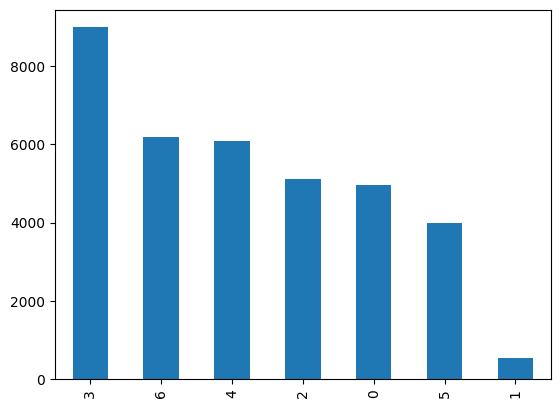

In [13]:
expression.emotion.value_counts().plot(kind='bar') 

`showing the dataset of each expression`

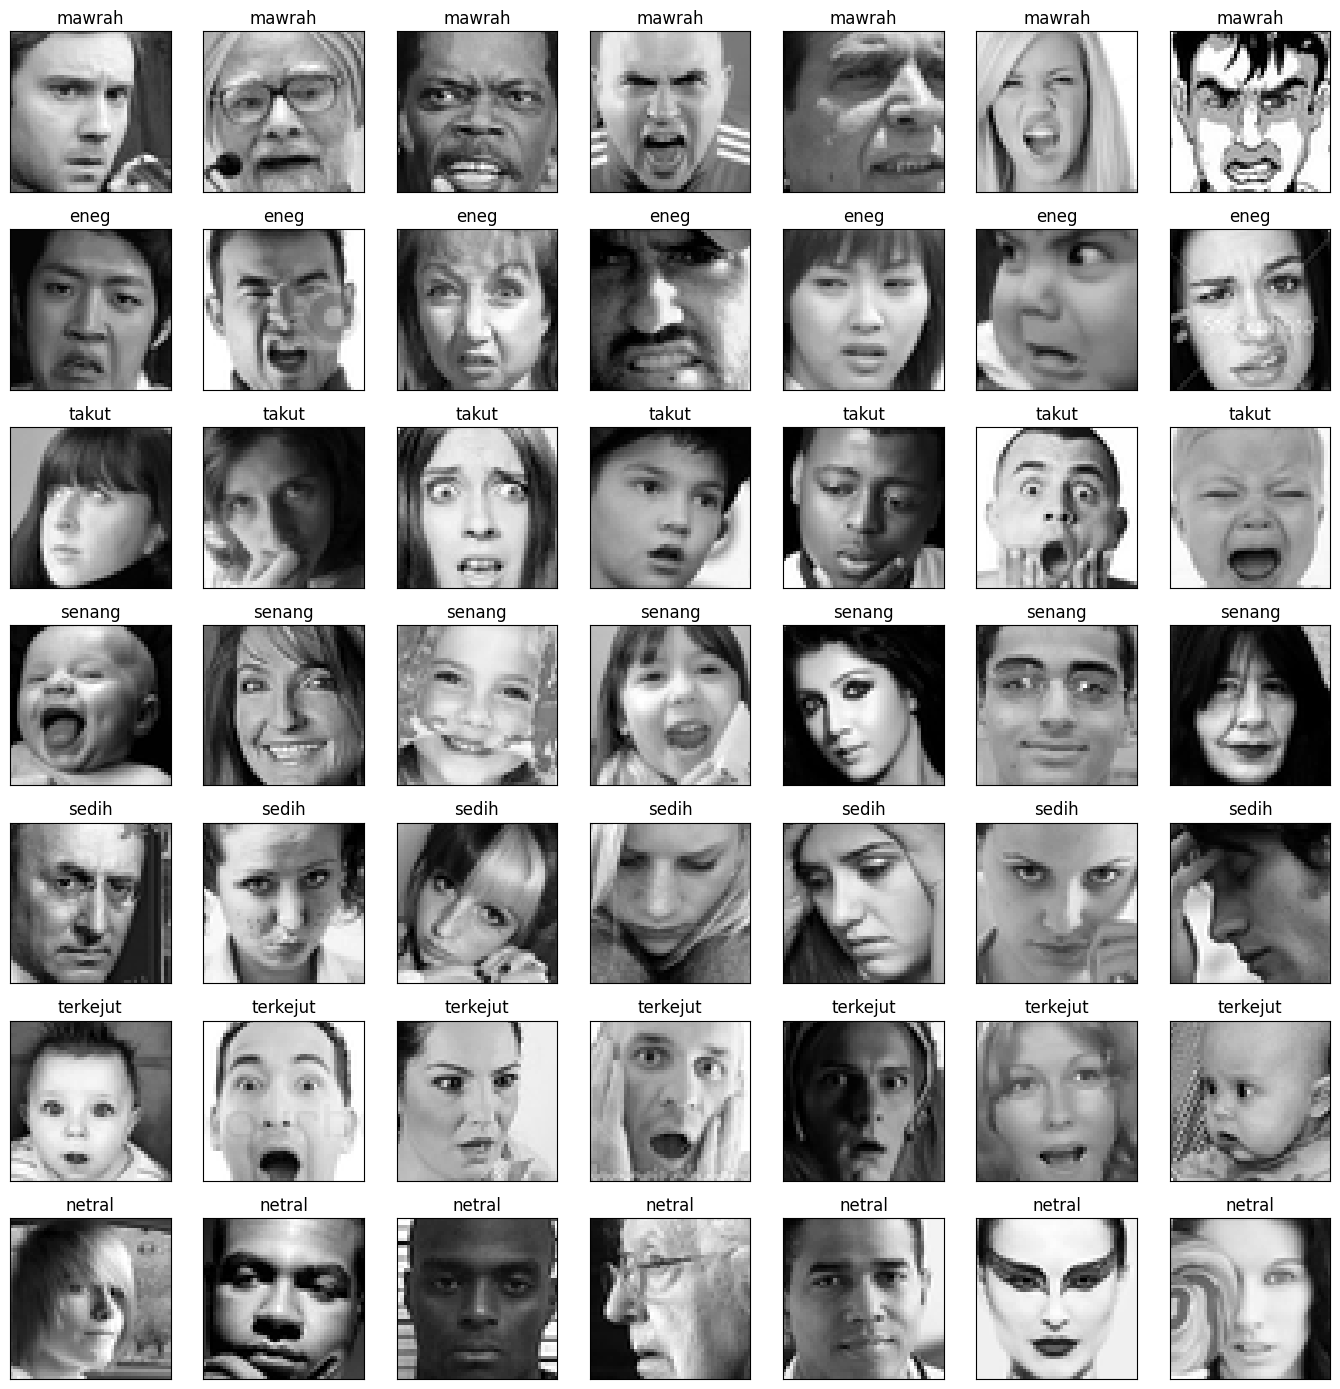

In [14]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(expression.emotion.unique()):
    for j in range(7):
        px = expression[expression.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

## Feature Engineering

`Now I will make the data compatible for neural networks`

In [16]:
img_array = expression.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

In [17]:
img_array.shape

(35887, 48, 48)

In [18]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


(35887, 48, 48, 3)

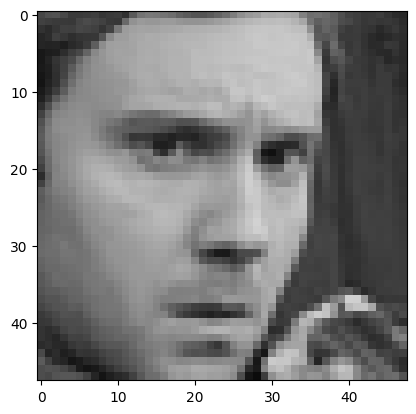

In [19]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [21]:
le = LabelEncoder()

img_labels = le.fit_transform(expression.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [22]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


`splitting the data into training and validation `

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [25]:
del expression
del img_features
del img_labels

In [26]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

`Normalizing results, as neural networks are very sensitive to unnormalized data.`

In [27]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [28]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

80134624/80134624 [==============================] - 16s 0us/step


`This code makes all layers of a VGG19 model non-trainable. This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights.`

In [29]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [30]:
def build_model(bottom_model, classes):
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [31]:
head = build_model(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

`I used two callbacks one is early stopping for avoiding overfitting training data and other ReduceLROnPlateau for learning rate.`

In [33]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [34]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [36]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

## Model Training

In [37]:
history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/25
1009/1009 [==============================] - 75s 57ms/step - loss: 1.4733 - accuracy: 0.4226 - val_loss: 1.2594 - val_accuracy: 0.5227 - lr: 1.0000e-04
Epoch 2/25
1009/1009 [==============================] - 59s 58ms/step - loss: 1.2497 - accuracy: 0.5218 - val_loss: 1.2040 - val_accuracy: 0.5453 - lr: 1.0000e-04
Epoch 3/25
1009/1009 [==============================] - 57s 57ms/step - loss: 1.1620 - accuracy: 0.5603 - val_loss: 1.0821 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 4/25
1009/1009 [==============================] - 58s 58ms/step - loss: 1.0939 - accuracy: 0.5868 - val_loss: 1.0917 - val_accuracy: 0.5982 - lr: 1.0000e-04
Epoch 5/25
1009/1009 [==============================] - 61s 60ms/step - loss: 1.0567 - accuracy: 0.6047 - val_loss: 1.0270 - val_accuracy: 0.6160 - lr: 1.0000e-04
Epoch 6/25
1009/1009 [==============================] - 58s 57ms/step - loss: 1.0203 - accuracy: 0.6163 - val_loss: 1.0039 - val_accuracy: 0.6347 - lr: 1.0000e-04
Epoch 7/25
1009/1009 [

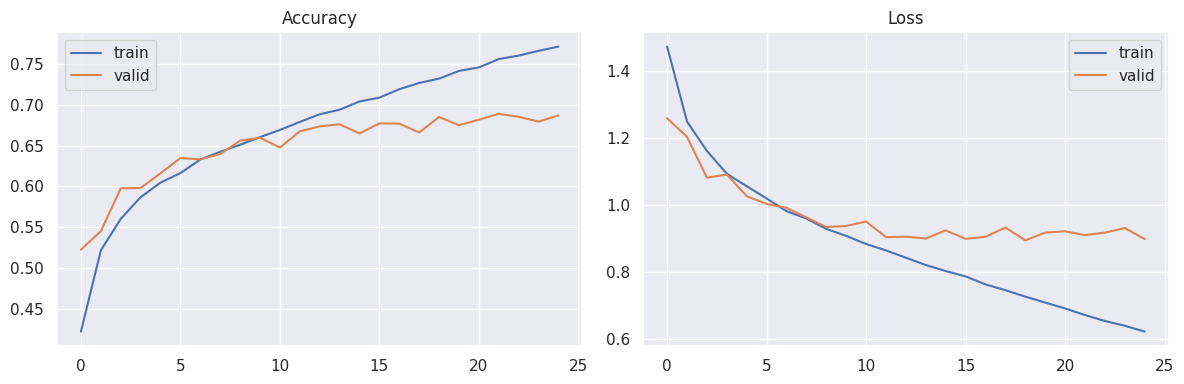

In [38]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

`from line plot above. our model tend to be overfitting.`

113/113 [==============================] - 2s 15ms/step
total wrong validation predictions: 1124


              precision    recall  f1-score   support

           0       0.65      0.60      0.62       495
           1       0.83      0.55      0.66        55
           2       0.59      0.46      0.51       512
           3       0.89      0.87      0.88       899
           4       0.57      0.55      0.56       608
           5       0.78      0.78      0.78       400
           6       0.58      0.78      0.66       620

    accuracy                           0.69      3589
   macro avg       0.70      0.65      0.67      3589
weighted avg       0.69      0.69      0.68      3589



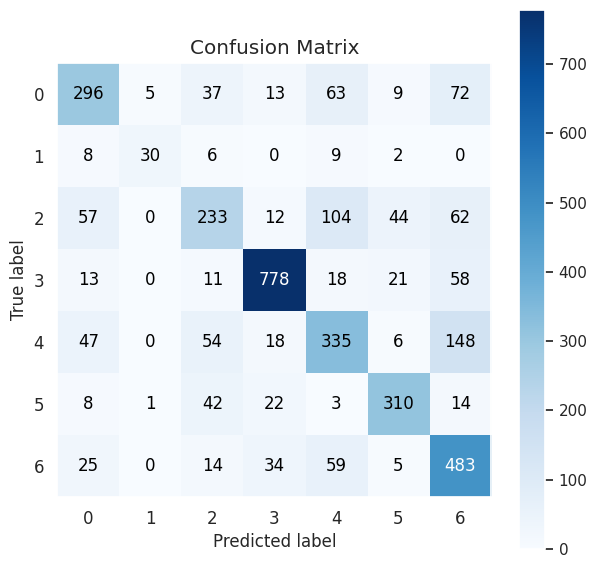

In [39]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

`our model has 69% accuracy which is not good enough to be implemented in real life situation. i prioritize using accuracy because i want to see a value that have a combination of each number. from confusion matrix, our model has a good job to predict someone who is happy or not in real and predict, i assume this is because happy segment has the most data train compare every other segment especially for segment 1, it really hard to predict and it shows that it has smallest value in recall`

## Model Saving

In [41]:
model.save('emotion_detection_model.h5')

## Overall Analysis

- `this dataset contains various fac expression from human such as happy, sad, disgust, netral, angry, suprise and angry and this dataset is not balance at all, the disgust segment has the smallest data comparing another segments `
- `our line plot, tend to be overfitting. the line has separated at the end from train and valid plot`
- `from confusion matrix, our model has a good job to predict someone who is happy or not in real and predict, i assume this is because happy segment has the most data train compare every other segment especially for segment 1, it really hard to predict and it shows that it has smallest value in recall`